## Regression (Figure 3-4, Table 3-6)

In [1]:
dir_path = '/Users/jeremyzyang/Library/CloudStorage/GoogleDrive-jeremy.z.yang@gmail.com/My Drive/tiktok_revision'
setwd(dir_path)

In [2]:
load('tiktok.RData')
options(warn = -1)

In [3]:
suppressWarnings(suppressMessages(library(data.table)))
suppressWarnings(suppressMessages(library(tidyverse)))
suppressWarnings(suppressMessages(library(lfe)))
suppressWarnings(suppressMessages(library(patchwork)))
suppressWarnings(suppressMessages(library(zoo)))
suppressWarnings(suppressMessages(library(doParallel)))
suppressWarnings(suppressMessages(library(staggered)))
suppressWarnings(suppressMessages(library(fixest)))
suppressWarnings(suppressMessages(library(faux)))
suppressWarnings(suppressMessages(library(stargazer)))
suppressWarnings(suppressMessages(library(xgboost)))
suppressWarnings(suppressMessages(library(caret)))

In [4]:
sessionInfo()

R version 4.2.1 (2022-06-23)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] caret_6.0-93      lattice_0.20-45   xgboost_1.6.0.1   stargazer_5.2.3  
 [5] faux_1.1.0        fixest_0.10.4     staggered_1.1     doParallel_1.0.17
 [9] iterators_1.0.14  foreach_1.5.2     zoo_1.8-11        patchwork_1.1.2  
[13] lfe_2.8-8         Matrix_1.5-1      forcats_0.5.2     stringr_1.4.1    
[17] dplyr_1.0.10      purrr_0.3.4       readr_2.1.3       tidyr_1.2.1      
[21] tibble_3.1.8      ggplot2_3.3.6     tidyverse_1.3.2   data.table_1.14.2

loaded via a names

In [5]:
ls()

[1] "dir_path"           "model_construction" "model_evaluation"  
[4] "own"                "search"

In [6]:
df = model_evaluation

In [7]:
df = df %>% group_by(taobao_id) %>% 
  mutate(treated_mean = mean(treated, na.rm = T))

df %>% distinct(taobao_id, .keep_all = T) %>%
  filter(treated_mean != 1) %>%
  pull(treated_mean) %>% table %>% sum

df_treat = filter(df, treated_mean != 1)
df_control = filter(df, treated_mean == 1)

treat_id = unique(df_treat$taobao_id)

[1] 259

#### Figure 3


	Pearson's product-moment correlation

data:  s2$pe_score and s2$rev_diff
t = 2.6393, df = 257, p-value = 0.008815
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.04138053 0.27881772
sample estimates:
      cor 
0.1624498 


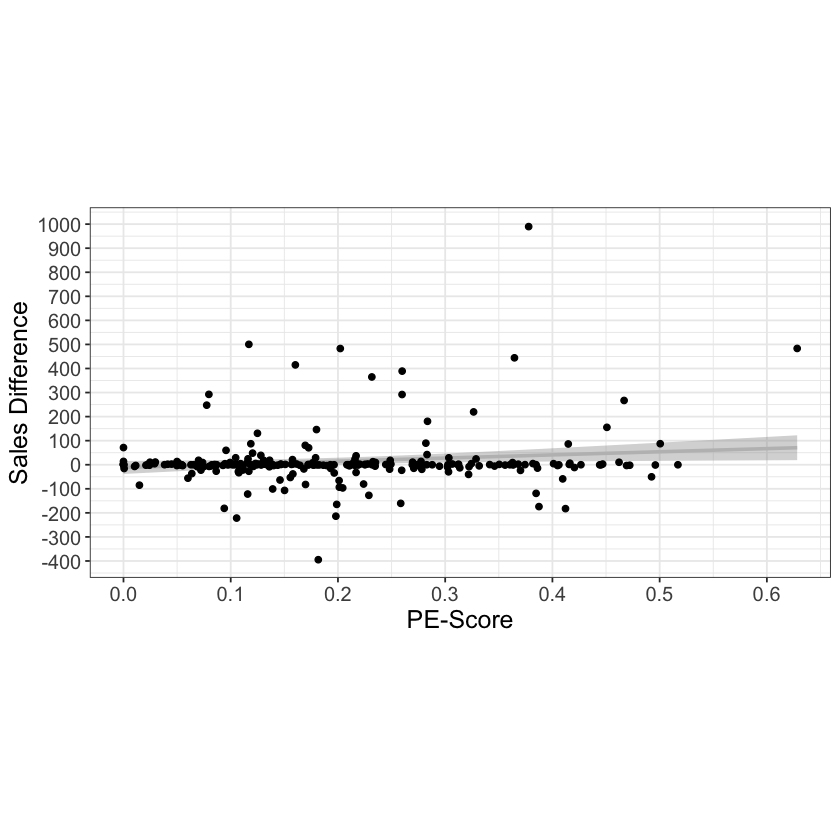

In [8]:
s = df_treat %>% 
  ungroup() %>%
  group_by(taobao_id, treated) %>% 
  mutate(
    avg_rev = mean(rev)
  ) %>%
  distinct(taobao_id, treated, .keep_all = T) %>%
  arrange(taobao_id) %>% 
  ungroup() %>%
  group_by(taobao_id) %>%
  mutate(count = n()) %>%
  filter(count == 2) %>%
  ungroup()

s = dcast(s, taobao_id ~ treated, value.var = c("avg_rev"))

s = left_join(s, df_treat %>% 
                distinct(taobao_id, .keep_all = T) %>%
                select(taobao_id, like, comment, share, pe_score), by = 'taobao_id') 

t = df_treat %>% distinct(taobao_id, .keep_all = T) %>% select(taobao_id, video_posted_time)

s= left_join(s, t, by = 'taobao_id')
s$rev_diff = s[,3] - s[,2]

s2 = s %>% distinct(taobao_id, .keep_all = T)

ggplot(s2,
           aes(pe_score, rev_diff)) +
  geom_smooth(method = 'lm', color = 'grey', formula = y ~ x) +
  geom_point() +
  xlab('PE-Score') + 
  ylab('Sales Difference') + 
  theme_bw() +
  theme(text = element_text(size=15)) +
  scale_y_continuous(
    limits = c(-400,1000),
          breaks=seq(-400, 1000, 100)
  ) +
  scale_x_continuous(
    breaks=seq(0, 1, 0.1)
  ) +
theme(aspect.ratio=2/4)

cor.test(s2$pe_score, s2$rev_diff)

#### Figure 4

In [9]:
# impute daily sales

id = unique(df$taobao_id)
rev_day = data.frame()

df = distinct(df, taobao_id, updated_time, .keep_all = T)

for (i in id) { # loop over all products 
df_p = select(df, rev, taobao_id, updated_time_rel) %>% filter(taobao_id == i) %>% arrange(updated_time_rel)
df_p$updated_time_rel = as.numeric(df_p$updated_time_rel)

s = full_seq(df_p$updated_time_rel, 1) # fill in missing dates
rev_day_p_c = data.frame(rep(i,length(s)), s)
colnames(rev_day_p_c) = c('taobao_id','updated_time_rel')

df_p = left_join(rev_day_p_c, df_p, by = c("taobao_id", "updated_time_rel"))
df_p = fill(df_p, rev) # imputing revenues on missing days by the previous value

rev_day_p = vector()

for (j in 1:nrow(df_p)) {

  rev_day_p[j] = ifelse( # imputing daily revenue
    df_p$updated_time_rel[j] == 0,
    df_p$rev[1]/30,
    ifelse(df_p$updated_time_rel[j] < 30,
                               df_p$rev[j] - df_p$rev[j-1] + df_p$rev[1]/30,
                               df_p$rev[j] - df_p$rev[j-1] + rev_day_p[j-30]
                               ))
}

df_p$rev_day = rev_day_p

rev_day = rbind(rev_day, df_p)

}

In [10]:
df$updated_time_rel = as.numeric(df$updated_time_rel)

df_day = left_join(rev_day, 
                     select(df, -rev), by = c('taobao_id','updated_time_rel')) %>% drop_na

In [11]:
df_day_treat = filter(df_day, taobao_id %in% treat_id)
df_day_control = filter(df_day, !(taobao_id %in% treat_id))

In [12]:
tau = vector()
gamma = vector()
r2 = vector()
r2_adj = vector()
  
for (i in seq(1,length(treat_id))) { # loop over all treated products
        
    df_day_treat_i = filter(df_day_treat, taobao_id == treat_id[[i]])
    df_day_i = rbind(df_day_treat_i, df_day_control)
    
    model = felm(rev_day ~ 
                   + treated + search                 
                 |as.factor(updated_time) + as.factor(taobao_id)|0|taobao_id + updated_time,
                 df_day_i
    )
    
    tau[i] = as.numeric(coef(summary(model))[1,1])
    gamma[i] = as.numeric(coef(summary(model))[2,1])
    r2[i] = summary(model)$r2
    r2_adj[i] = summary(model)$r2adj
    
  }

In [13]:
d = data.frame(taobao_id = treat_id, tau = tau, gamma = gamma, r2 = r2, r2_adj = r2_adj)

d = left_join(d, 
              df %>% 
              distinct(taobao_id, .keep_all = T) %>% 
              select(taobao_id,
                            pe_score, p_score, e_score, like, comment, share,
                               price, discount, hedonic, deliberate, avg_search, category,
                               gender,fans,avg_play,influencer_price,expected_cpm,order_cnt, true_id,
                    score_mean_like_std, score_mean_comment_std, score_mean_unsup_std), by = 'taobao_id')

#### Figure 4

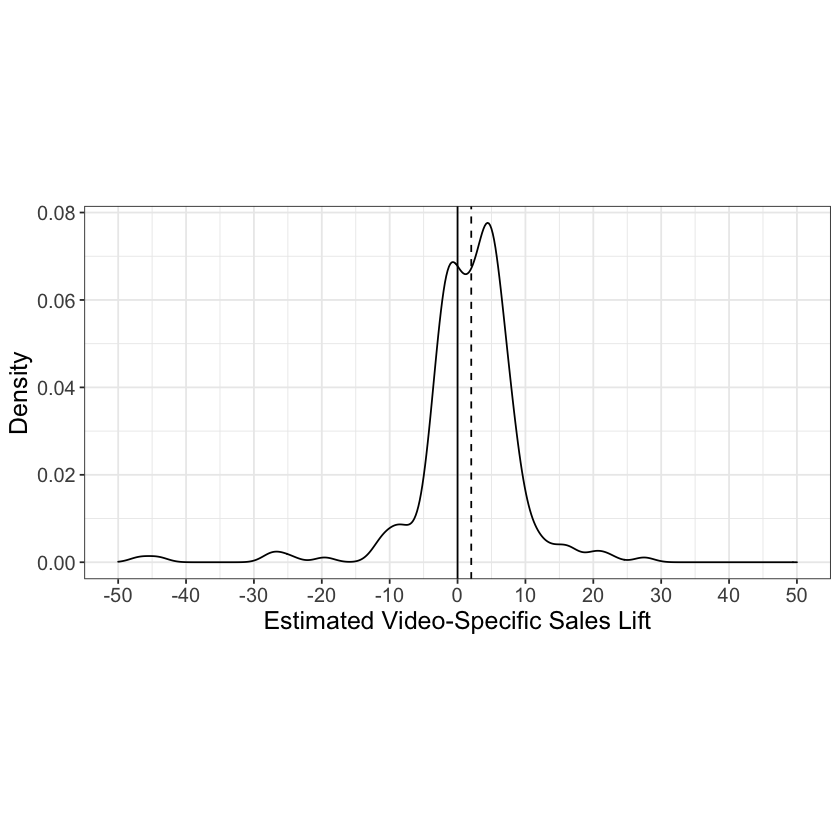

In [14]:
ggplot(d 
            %>% mutate(high = ifelse(pe_score >= median(pe_score), '1', '0')), 
            aes(x=tau)) + 
  geom_density() + geom_vline(xintercept=0) + 
  scale_x_continuous(
    limits = c(-50,50),
    breaks=seq(-50, 50, 10)
  ) +

geom_vline(aes(xintercept=mean(tau)),linetype="dashed") + 

theme_bw() +

  xlab('Estimated Video-Specific Sales Lift') + 
  ylab('Density') + 
  theme(text = element_text(size=15)) +
theme(aspect.ratio=2/4)

#### Table 4

In [15]:
d %>% 
select(tau, gamma) %>% 
as.data.frame %>% 
stargazer(type = 'text', digits = 2, median = T)


Statistic  N  Mean St. Dev.   Min   Median  Max  
-------------------------------------------------
tau       259 2.02  47.53   -123.62  2.06  699.20
gamma     259 0.41   0.01    0.39    0.40   0.49 
-------------------------------------------------


#### Table 5

In [16]:
m1 = felm(tau ~ 
               + pe_score 
                 , d %>% mutate(
                     fans = fans/1000000,
                                avg_play = avg_play/1000000,
                               influencer_price = influencer_price/1000000,
                               expected_cpm = expected_cpm/1000000))

m2 = felm(tau ~ 
          + e_score
                 , d %>% mutate(
                     fans = fans/1000000,
                                avg_play = avg_play/1000000,
                               influencer_price = influencer_price/1000000,
                               expected_cpm = expected_cpm/1000000))

m3 = felm(tau ~ 
               + p_score 
                 , d %>% mutate(
                     fans = fans/1000000,
                                avg_play = avg_play/1000000,
                               influencer_price = influencer_price/1000000,
                               expected_cpm = expected_cpm/1000000))

m4 = felm(tau ~ 
          + p_score*e_score -p_score -e_score
                 , d %>% mutate(
                     fans = fans/1000000,
                                avg_play = avg_play/1000000,
                               influencer_price = influencer_price/1000000,
                               expected_cpm = expected_cpm/1000000))

m5 = felm(tau ~ 
               + pe_score 
              + p_score*e_score
                 , d %>% mutate(
                     fans = fans/1000000,
                                avg_play = avg_play/1000000,
                               influencer_price = influencer_price/1000000,
                               expected_cpm = expected_cpm/1000000))

m6 = felm(tau ~ 
               + pe_score 
             + p_score*e_score
                   
             + avg_search 
               + price
               + discount
             
               + fans
               + avg_play
               + influencer_price
               + expected_cpm
               + order_cnt 
               + gender
             | category
                 , d %>% mutate(
                     fans = fans/1000000,
                                avg_play = avg_play/1000000,
                               influencer_price = influencer_price/1000000,
                               expected_cpm = expected_cpm/1000000))

vars.order = c("pe_score", "e_score", "p_score", "p_score:e_score", 
               "gender", "fans", "avg_play", "influencer_price", "expected_cpm", "order_cnt",
               "avg_search", "price", "discount", 
               "Constant")

stargazer(m1,m2,m3,m4,m5,m6,
          digits = 2,
          type = 'text',
          star.char = c("+", "*", "**", "***"),
          star.cutoffs = c(.1, .05, .01, .001),
          omit = c("Constant"),
          order=paste0("^", vars.order , "$")
         )


                                                             Dependent variable:                                         
                    -----------------------------------------------------------------------------------------------------
                                                                     tau                                                 
                          (1)              (2)              (3)              (4)              (5)              (6)       
-------------------------------------------------------------------------------------------------------------------------
pe_score                68.27**                                                            101.32***        100.79***    
                        (22.87)                                                             (27.04)          (28.91)     
                                                                                                                         
e_score                

#### Table 6

In [17]:
# cross validation

set.seed(101)

x <- sparse.model.matrix(tau ~ ., data = select(d, tau,
                                                                                    pe_score,
                                                                                                            p_score, e_score,
                                                 fans, avg_play, influencer_price, expected_cpm, order_cnt,gender,

                                                    avg_search, price, discount, category,


                                                           ))[,-1]

xgb = xgb.cv(data = as.matrix(x), 
              label = d$tau, nround = 50, verbose = 0, nfold = 5, 
            )

xgb

#r2
r2 = 1 - min(xgb$evaluation_log[['test_rmse_mean']])^2/mean((d$tau - mean(d$tau))^2)
r2

# adjusted r2
r2_adj = 1- (1-r2)*(dim(x)[1]-1)/(dim(x)[1]-dim(x)[2]-1)
r2_adj

##### xgb.cv 5-folds
 iter train_rmse_mean train_rmse_std test_rmse_mean test_rmse_std
    1      39.0772875    10.54035971       36.05169      31.08380
    2      33.4142219     8.84807055       36.96302      30.75635
    3      28.6220898     7.44856501       37.59555      30.59560
    4      24.6454049     6.19616436       38.23619      30.52063
    5      21.3270931     5.13248441       38.86981      30.37831
    6      18.5094739     4.11137939       39.32107      30.30202
    7      16.0367829     3.52810191       39.59240      30.28652
    8      13.9270641     3.01668420       39.79739      30.34144
    9      12.0721076     2.62973165       39.95269      30.35470
   10      10.5545535     2.18135224       40.13806      30.33292
   11       9.3498402     1.77575149       40.20161      30.39690
   12       8.2369352     1.35361965       40.34054      30.43158
   13       7.3771788     1.19895613       40.51074      30.44061
   14       6.5338442     1.01176551       40.55232    

[1] 0.4224731

[1] 0.3712999

In [18]:
# variable importance

set.seed(101)

x <- sparse.model.matrix(tau ~ ., data = select(d, tau,
                                                                                    pe_score,
                                                                                                            p_score, e_score,
                                                 fans, avg_play, influencer_price, expected_cpm, order_cnt,gender,

                                                    avg_search, price, discount, category,


                                                           ) %>% drop_na)[,-1]

xgb = xgboost(data = as.matrix(x), 
              label = d$tau, nround = 20, verbose = 0)

xgb.importance(model = xgb) %>% top_n(10, Gain) %>% stargazer(summary=FALSE, rownames=FALSE, type = 'text')


Feature             Gain  Cover Frequency
-----------------------------------------
pe_score            0.858 0.228   0.289  
expected_cpm        0.039 0.077   0.076  
p_score             0.033 0.198   0.141  
discount            0.018 0.091   0.096  
e_score             0.017 0.004   0.048  
fans                0.014 0.095   0.079  
avg_search          0.009 0.101   0.069  
order_cnt           0.003 0.062   0.038  
price               0.003 0.018   0.048  
categoryElectronics 0.002 0.015   0.014  
-----------------------------------------


#### incentive alignment

In [19]:
m = lm(score_mean ~ own + category + fans + gender + order_cnt + price + discount, 
       data = own)
stargazer(m,
          digits = 2,
          type = 'text',
          star.char = c("+", "*", "**", "***"),
          star.cutoffs = c(.1, .05, .01, .001),
          omit = c("Constant"),
          order=paste0("^", vars.order , "$")
         )


                          Dependent variable:    
                      ---------------------------
                              score_mean         
-------------------------------------------------
gender                          9.29***          
                                (2.33)           
                                                 
fans                            -0.0000          
                               (0.0000)          
                                                 
order_cnt                       -0.08**          
                                (0.03)           
                                                 
price                           0.0000           
                               (0.0000)          
                                                 
discount                         0.003           
                                (0.002)          
                                                 
own                             28.93**          

In [20]:
summary(m)$coefficients[2,1]/mean(filter(own, own == 0) %>% pull(score_mean))

[1] 0.3097037